Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Results saved to: /content/drive/MyDrive/results/hc_measurement_results.csv

=== HC MEASUREMENT COMPARISON ===
+-------------+-------------------+----------------+---------------------+--------------------------+------------------+-----------------+
| Filename    |   Pixel Size (mm) |   True HC (mm) |   Predicted HC (mm) |   Predicted HC Mask (mm) |   Abs Error (mm) |   Rel Error (%) |
+=============+===================+================+=====================+==========================+==================+=================+
| 130_HC.png  |            0.1148 |          96.8  |               12.94 |                     8.72 |            83.86 |           86.64 |
+-------------+-------------------+----------------+---------------------+--------------------------+------------------+-----------------+
| 136_HC.png  |            0.0726 |         100.83 |               24.96 |                    21.29 |            75.87 |           75.25 |
+-------------+-------------------+----------------+--

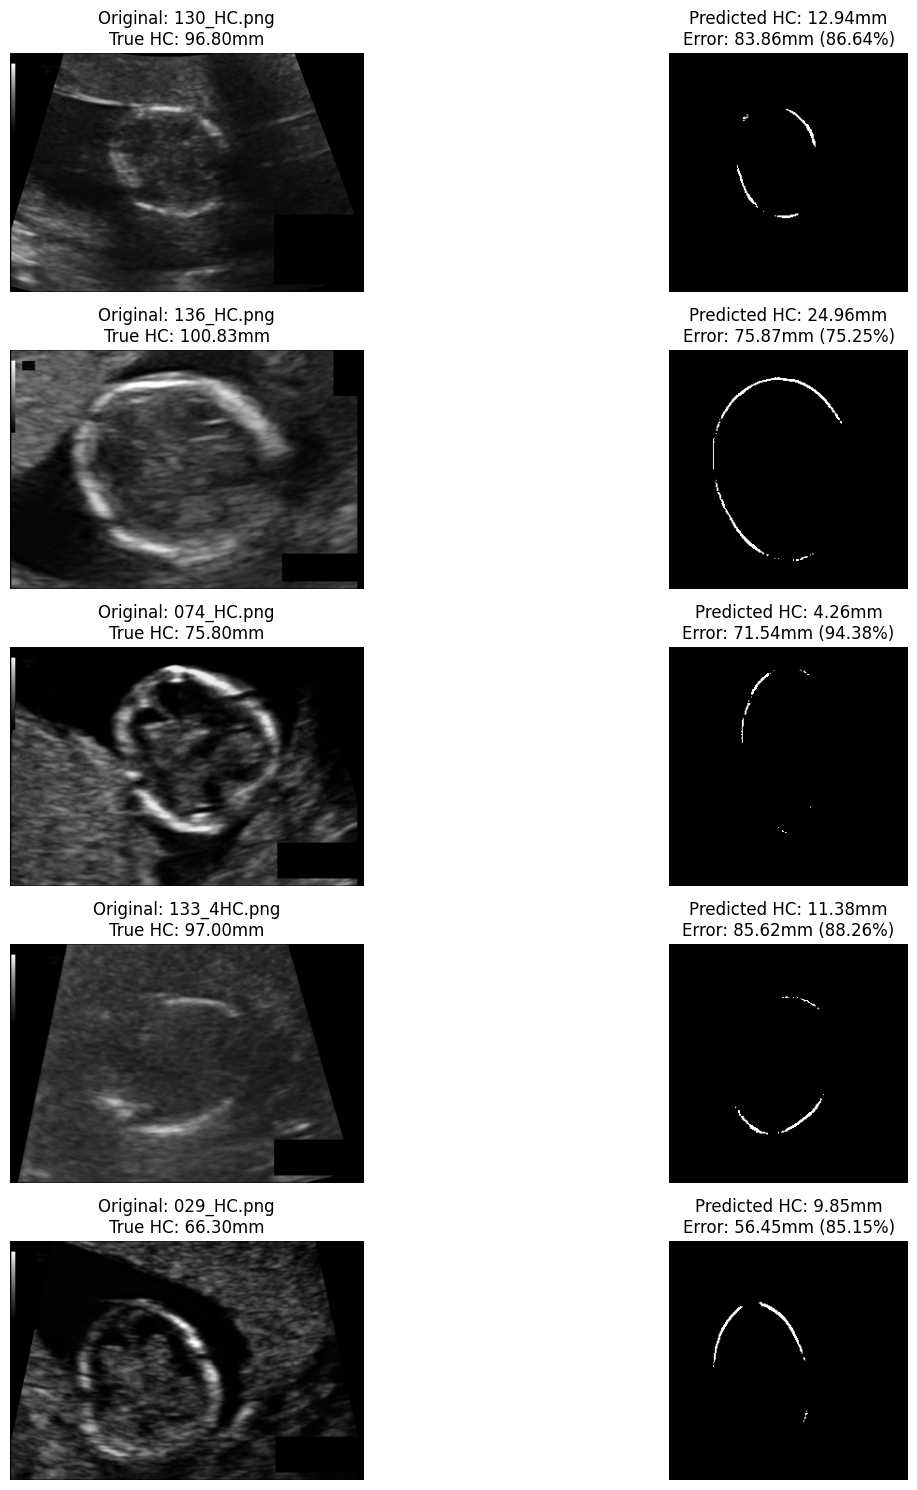

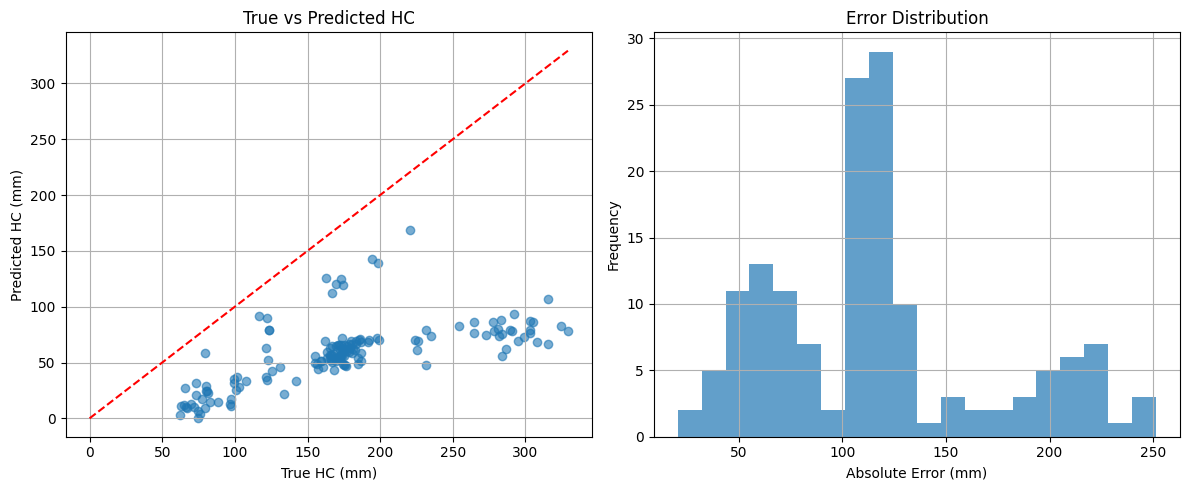

In [10]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from tabulate import tabulate

# Define paths relative to script location
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
MODEL_PATH = os.path.join(BASE_DIR, 'best_model.h5')
TEST_IMAGE_DIR = os.path.join(BASE_DIR, 'dataset/test_dataset/images')
TEST_MASK_DIR = os.path.join(BASE_DIR, 'dataset/test_dataset/masks')
CSV_PATH = os.path.join(BASE_DIR, 'dataset/pixel_size_and_HC.csv')
OUTPUT_DIR = os.path.join(BASE_DIR, 'results')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Custom metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def load_model():
    """Load the trained model with custom objects"""
    try:
        return tf.keras.models.load_model(
            MODEL_PATH,
            custom_objects={
                'dice_coef': dice_coef,
                'dice_loss': dice_loss,
                'bce_dice_loss': bce_dice_loss
            }
        )
    except Exception as e:
        print(f"Error loading model with custom objects: {e}")
        return tf.keras.models.load_model(MODEL_PATH)

def calculate_hc(mask, pixel_size):
    """Calculate head circumference from binary mask using contours"""
    mask = mask.squeeze().astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0
    largest_contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(largest_contour, True)
    return perimeter * pixel_size

def process_image(img_path, target_size=(256, 256)):
    """Load and preprocess single image"""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image {img_path}")
    img = cv2.resize(img, target_size)
    img = np.expand_dims(img, axis=-1)
    return img.astype(np.float32) / 255.0

def main():
    print("Loading model and data...")
    model = load_model()
    df = pd.read_csv(CSV_PATH)

    # Clean filename column to match image names
    df['filename'] = df['filename'].apply(lambda x: os.path.basename(x).split('.')[0] + '.png')

    results = []
    processed_files = 0

    print("\nProcessing test images...")
    for filename in os.listdir(TEST_IMAGE_DIR):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            # Find matching CSV entry
            csv_row = df[df['filename'] == filename]
            if len(csv_row) == 0:
                print(f"No CSV entry for {filename}, skipping...")
                continue

            pixel_size = csv_row['pixel size(mm)'].values[0]
            true_hc = csv_row['head circumference (mm)'].values[0]

            # Process image
            img_path = os.path.join(TEST_IMAGE_DIR, filename)
            img = process_image(img_path)
            img_batch = np.expand_dims(img, axis=0)

            # Predict
            pred_mask = model.predict(img_batch, verbose=0)[0]
            pred_mask = (pred_mask > 0.5).astype(np.uint8)
            pred_hc = calculate_hc(pred_mask, pixel_size)

            # Calculate errors
            error_mm = abs(pred_hc - true_hc)
            error_percent = (error_mm / true_hc) * 100 if true_hc != 0 else 0

            results.append({
                'Filename': filename,
                'Pixel Size (mm)': f"{pixel_size:.4f}",
                'True HC (mm)': f"{true_hc:.2f}",
                'Predicted HC (mm)': f"{pred_hc:.2f}",
                'Abs Error (mm)': f"{error_mm:.2f}",
                'Rel Error (%)': f"{error_percent:.2f}"
            })

            processed_files += 1
            if processed_files % 10 == 0:
                print(f"Processed {processed_files} images...")

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

    # Save and display results
    if results:
        results_df = pd.DataFrame(results)
        results_csv_path = os.path.join(OUTPUT_DIR, 'hc_results.csv')
        results_df.to_csv(results_csv_path, index=False)

        print("\n=== RESULTS SUMMARY ===")
        print(f"Processed {len(results_df)} images successfully")
        print(f"Results saved to: {results_csv_path}")

        # Calculate statistics
        errors = results_df['Abs Error (mm)'].astype(float)
        stats = {
            'Metric': ['Mean', 'Median', 'Std Dev', 'Max', 'Min'],
            'Abs Error (mm)': [
                errors.mean(),
                errors.median(),
                errors.std(),
                errors.max(),
                errors.min()
            ]
        }
        stats_df = pd.DataFrame(stats)

        print("\n=== ERROR STATISTICS ===")
        print(tabulate(stats_df, headers='keys', tablefmt='grid'))

        # Visualize samples
        visualize_samples(results_df, TEST_IMAGE_DIR, model)
    else:
        print("No valid results were generated.")

def visualize_samples(results_df, image_dir, model, num_samples=3):
    """Visualize sample predictions"""
    print("\nGenerating sample visualizations...")
    plt.figure(figsize=(15, 5*num_samples))

    sample_rows = results_df.head(num_samples).iterrows()
    for i, (_, row) in enumerate(sample_rows):
        img_path = os.path.join(image_dir, row['Filename'])
        img = process_image(img_path)

        # Get prediction
        img_batch = np.expand_dims(img, axis=0)
        pred_mask = model.predict(img_batch, verbose=0)[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Plot original
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Original: {row['Filename']}\nTrue HC: {row['True HC (mm)']}mm")
        plt.axis('off')

        # Plot prediction
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title(f"Predicted HC: {row['Predicted HC (mm)']}mm\nError: {row['Abs Error (mm)']}mm")
        plt.axis('off')

    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, 'sample_predictions.png')
    plt.savefig(output_path)
    print(f"Sample visualizations saved to: {output_path}")
    plt.show()

if __name__ == "__main__":
    main()